Corresponding to the main text section on SiT representation analsys

In [1]:
import torch 
import torch as th 
import torch.nn as nn
import os
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from stats_plot_utils import saveallforms, add_rectangles

### Prep training data

In [24]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [28]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


### Experiment sweeping

In [3]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch:07d}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [6]:
!ls {exproot}/014*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/014-SiT_B_1-stream1_6M_all-Linear-velocity-None:
args.json  checkpoints	dataset_idx.pkl  log.txt  samples  tensorboard_logs

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None:
args.json    dataset_idx.pkl  repr_classifier  tensorboard_logs
checkpoints  log.txt	      samples


In [7]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"

## Succeed run : 

In [9]:
expname = r"014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None"
r"013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]
# ckpt_path = join(ckptdir, "1000000.pt")
syn_df_SiT = sweep_classifier_result(repr_dir, t_list=[0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0,], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=True)

In [10]:
syn_df_SiT.to_csv(join(repr_dir, "repr_classifier_synopsis_EMA.csv"), index=False)
syn_df_SiT.to_csv(join(figexpdir, "repr_classifier_synopsis_EMA.csv"), index=False)

In [11]:
# find max and which row
print("Best classification result: ")
syn_df_SiT.loc[syn_df_SiT['Test Accuracy'].idxmax()]

Best classification result: 


Layer             blocks.11
Test Accuracy      0.996375
Train Accuracy          1.0
t                       0.9
epoch                700000
dimred             avgtoken
Name: 829, dtype: object

In [12]:
# find max and which row
print("Top 5 classification result: ")
syn_df_SiT.loc[ syn_df_SiT['Test Accuracy'].nlargest(10).index ]

Top 5 classification result: 


Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
829  blocks.11       0.996375        1.000000  0.90   700000  avgtoken
839  blocks.11       0.996375        1.000000  0.90  1000000  avgtoken
819  blocks.11       0.995150        0.999992  0.90   500000  avgtoken
828   blocks.8       0.994975        1.000000  0.90   700000  avgtoken
838   blocks.8       0.994875        1.000000  0.90  1000000  avgtoken
818   blocks.8       0.993875        0.999975  0.90   500000  avgtoken
749  blocks.11       0.986575        0.997008  0.80   500000  avgtoken
759  blocks.11       0.986425        0.997317  0.80   700000  avgtoken
898   blocks.8       0.984575        0.998758  0.95   700000  avgtoken
748   blocks.8       0.983500        0.995417  0.80   500000  avgtoken

In [93]:
# find max and which row
print("Best classification result: ")
# find Layer == 'blocks.11' t== 25.0 epoch == 1000000
syn_df_SiT.loc[ (syn_df_SiT['Layer'] == 'blocks.11') & 
                (syn_df_SiT['t'] == 25.0) & 
                (syn_df_SiT['epoch'] == 1000000) ]

Best classification result: 


Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
274  blocks.11       0.987625             1.0  25.0  1000000    pca384
279  blocks.11       0.997825             1.0  25.0  1000000  avgtoken

### Scaling with diffusion time

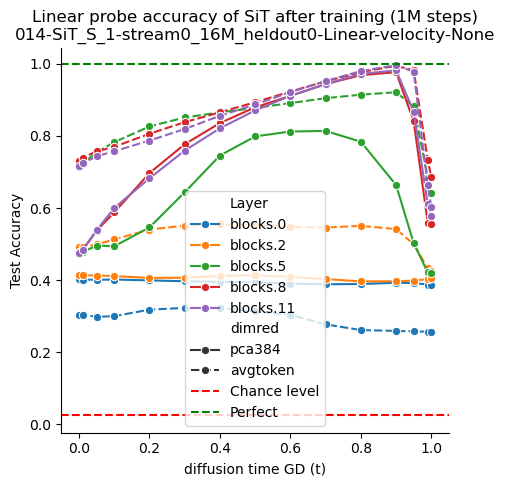

In [14]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[syn_df_SiT.epoch==1000000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_alldimred_EMA", figh)

The first two dots were t=0 and t=1 which maybe weird due to lack of training? / too close to the clean image 

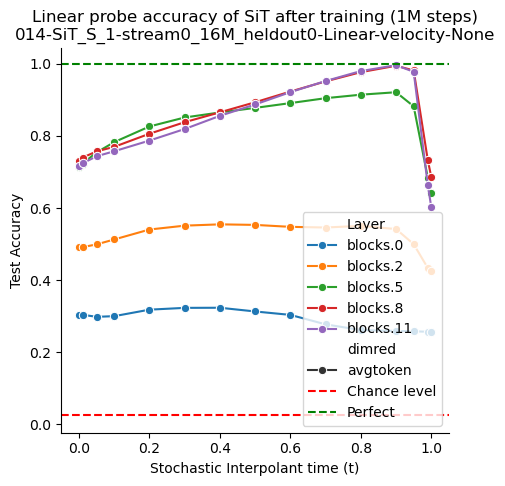

In [15]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==1000000) & (syn_df_SiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA", figh)

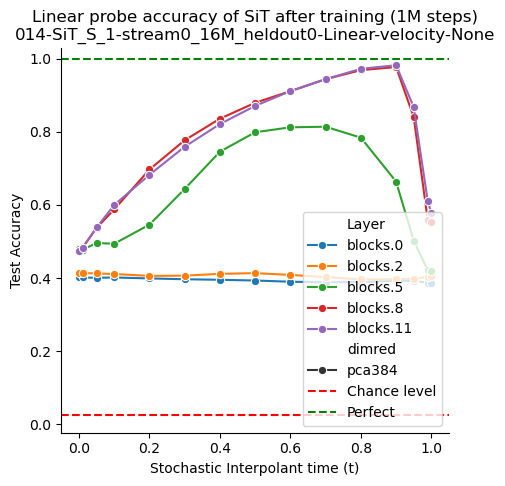

In [16]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==1000000) & (syn_df_SiT.dimred=="pca384")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_pca384_EMA", figh)

### Scaling with training time

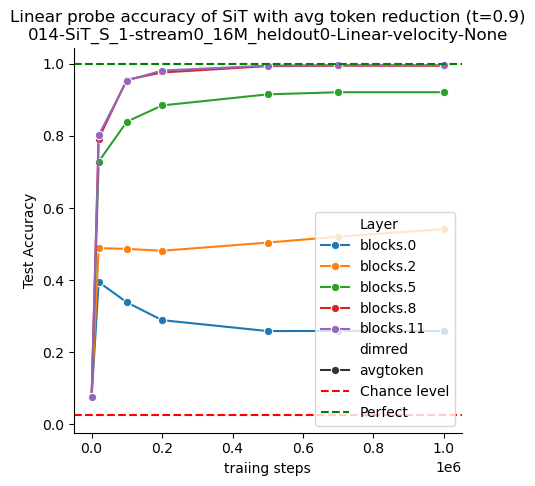

In [17]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="avgtoken")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_avgtoken_EMA", figh)
plt.show()

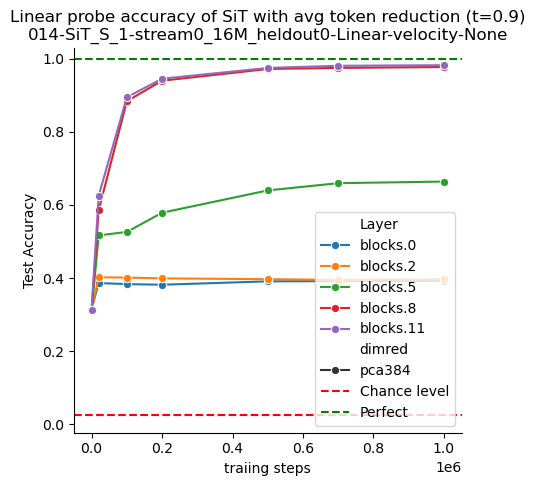

In [18]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="pca384")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_pca384_EMA", figh)
plt.show()

### Scaling with layer depth

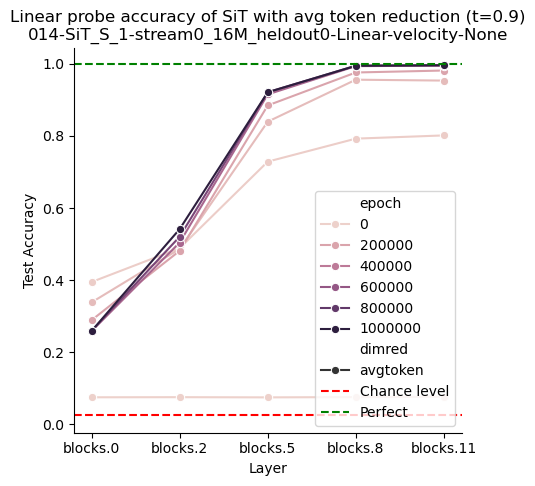

In [19]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="avgtoken")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_avgtoken_EMA", figh)

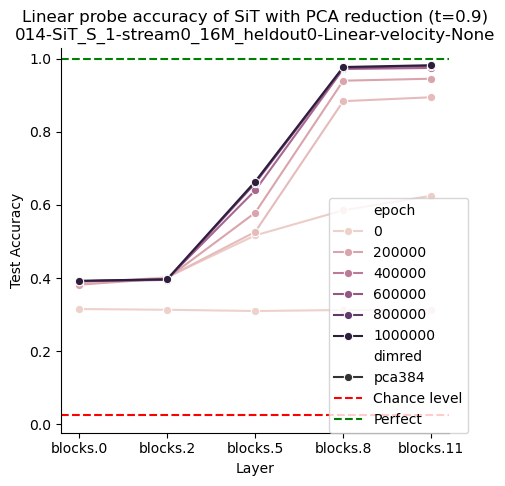

In [21]:
t_scalar = 0.9
figh = plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="pca384")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of SiT with PCA reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
# put legend outside
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.0), borderaxespad=0.)
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_pca384_EMA", figh)

### Error splitting plot 

In [30]:
from rule_new_utils import attribute_dict, relation_dict
def visualize_cm(cm, heldout_rules, titlestr=""):
    figh1 = plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
    plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh2, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    return figh1, figh2
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

In [112]:
!ls {repr_dir}/results_col_t25_0_avgtoken_ckpt1000000.pkl

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0020000EMA.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0020000.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0100000EMA.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/repr_classifier/results_col_t0_0_avgtoken_ckpt0100000.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_202407

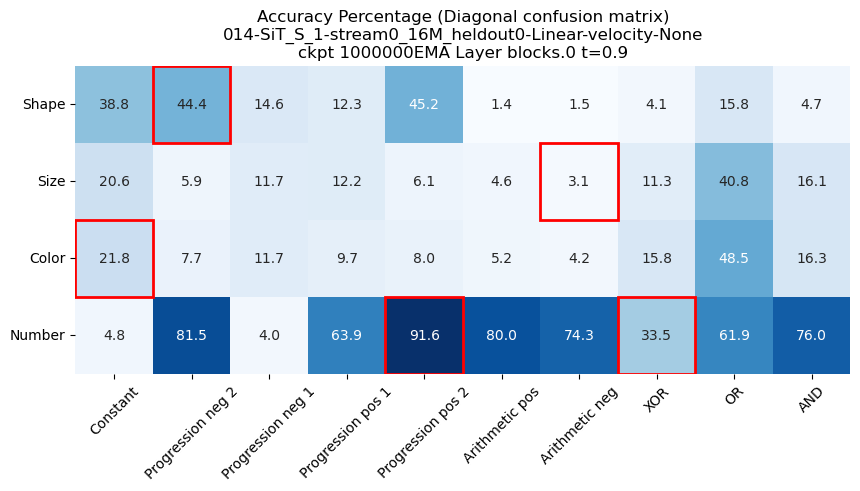

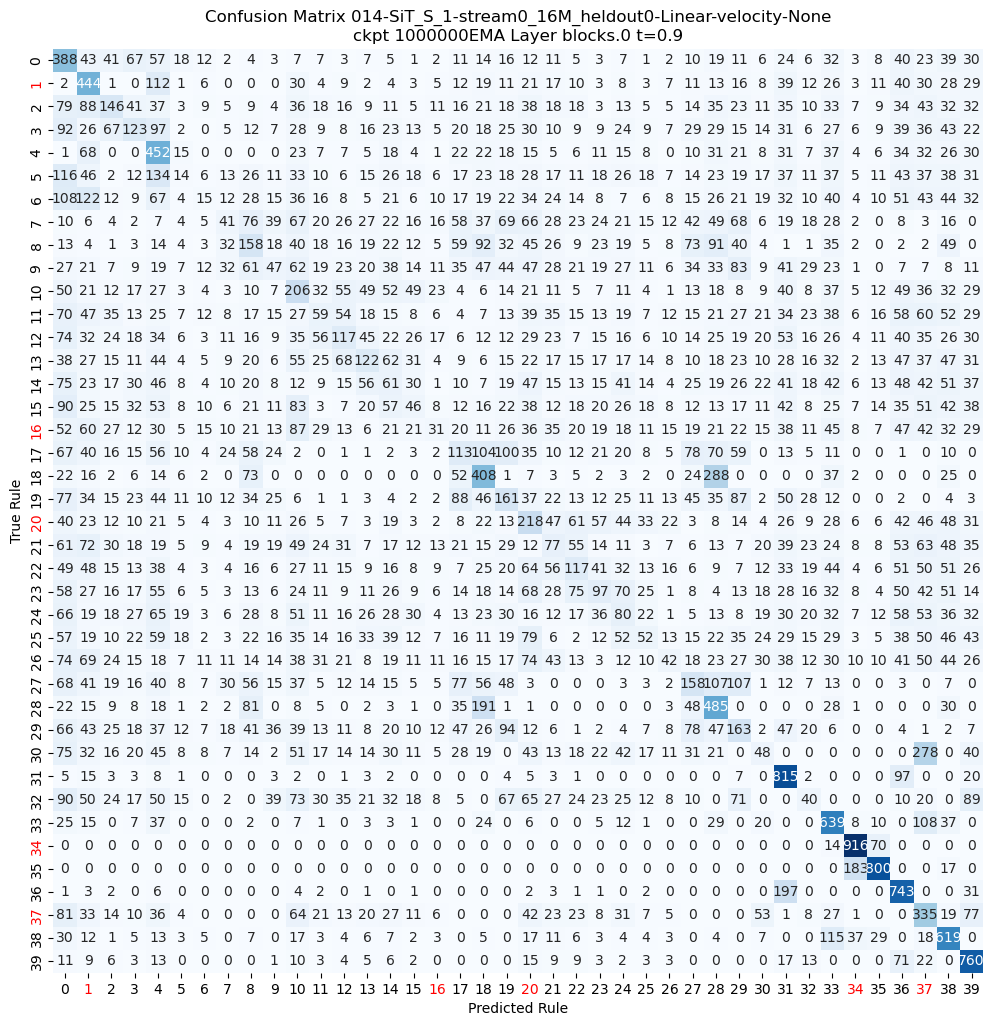

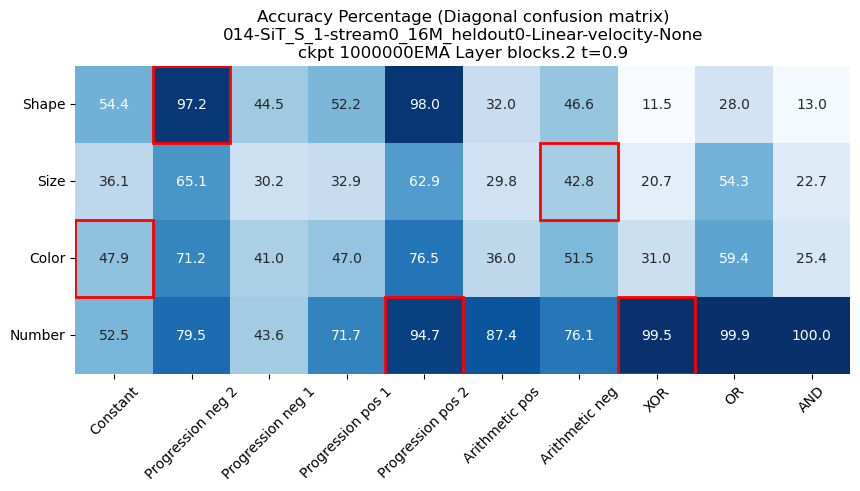

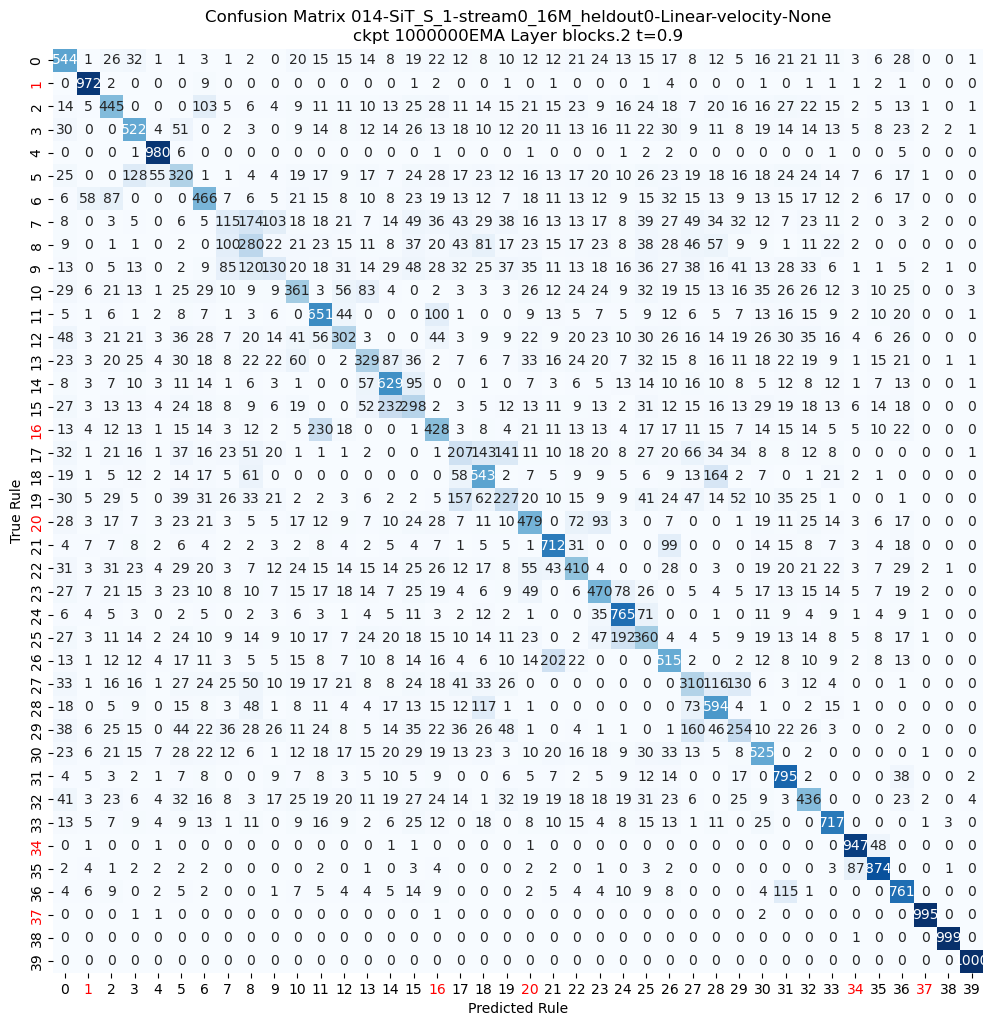

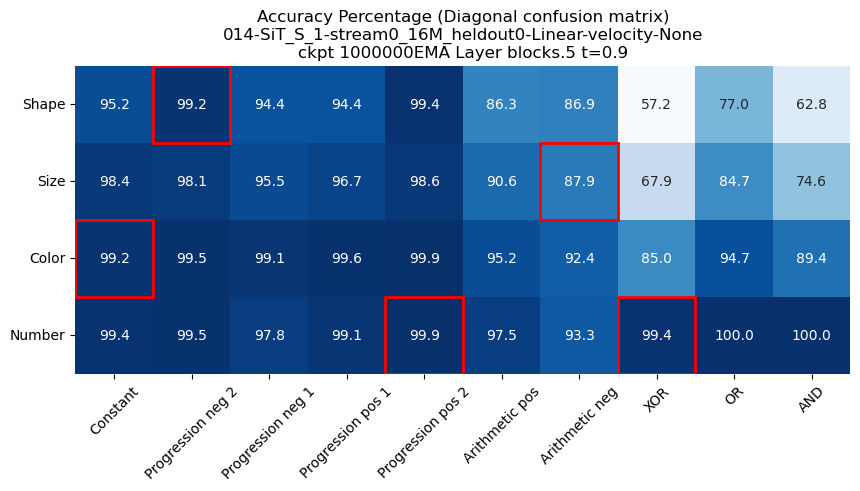

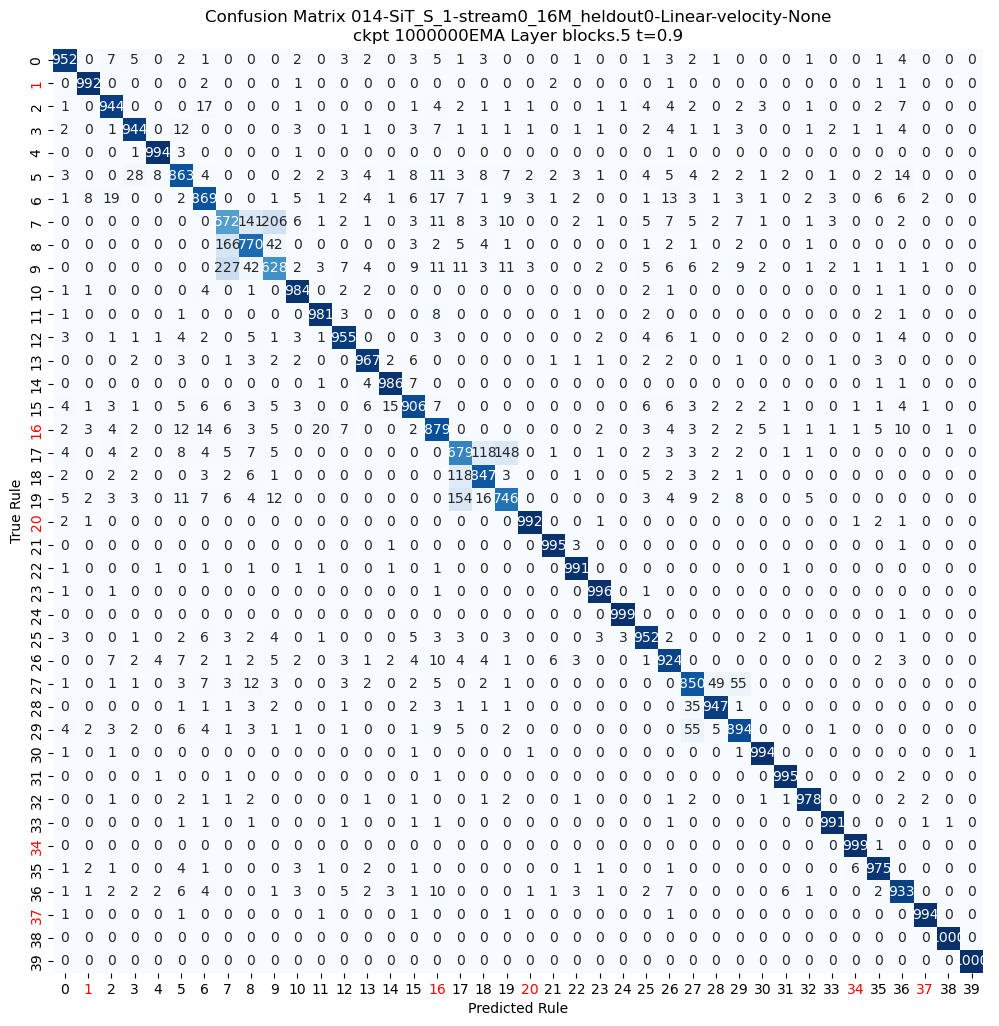

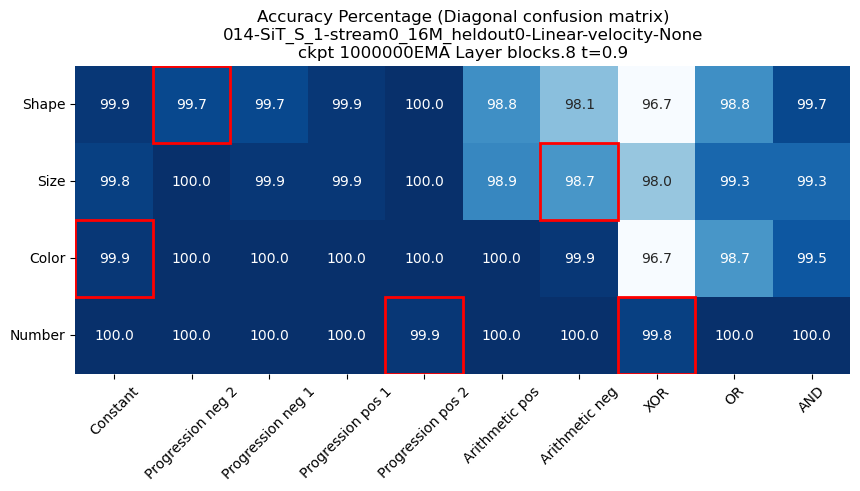

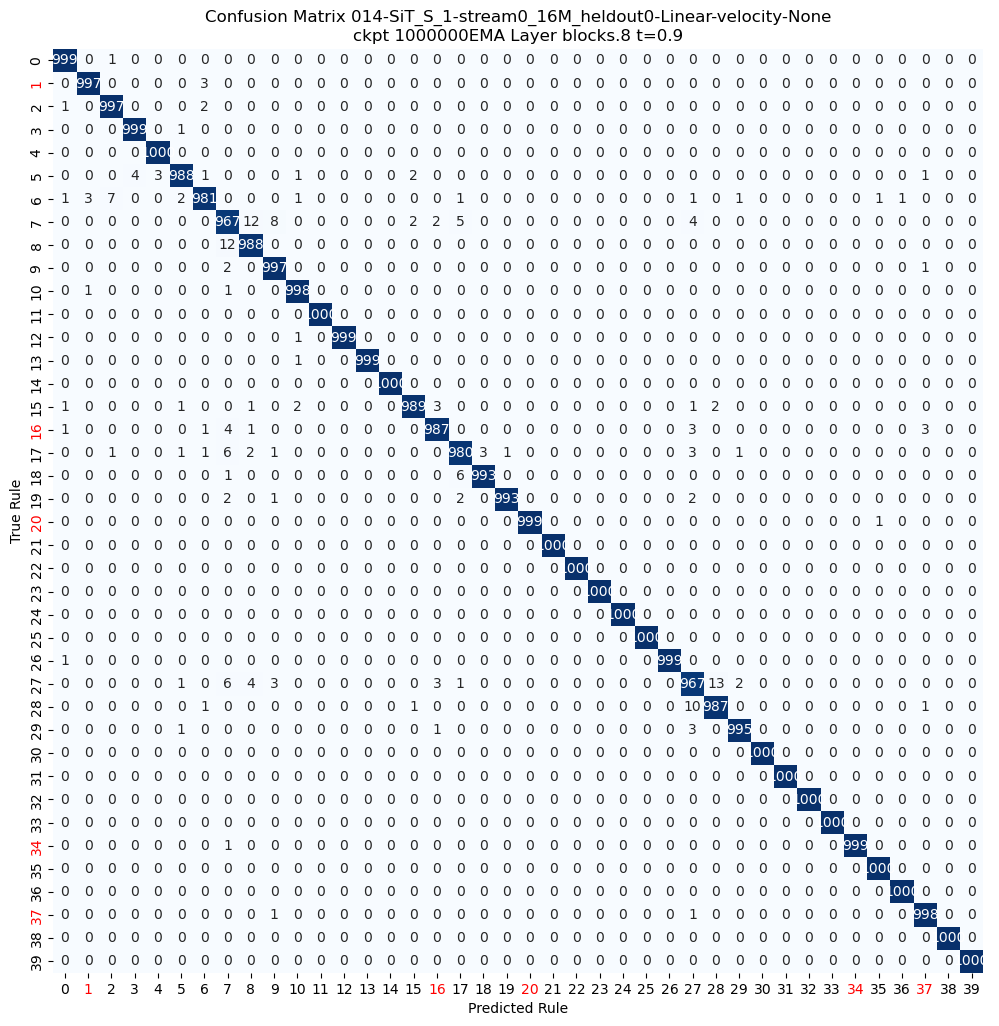

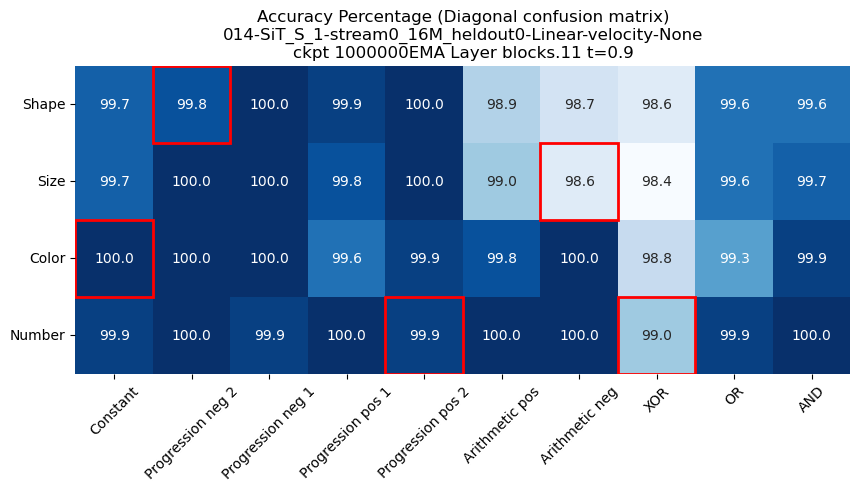

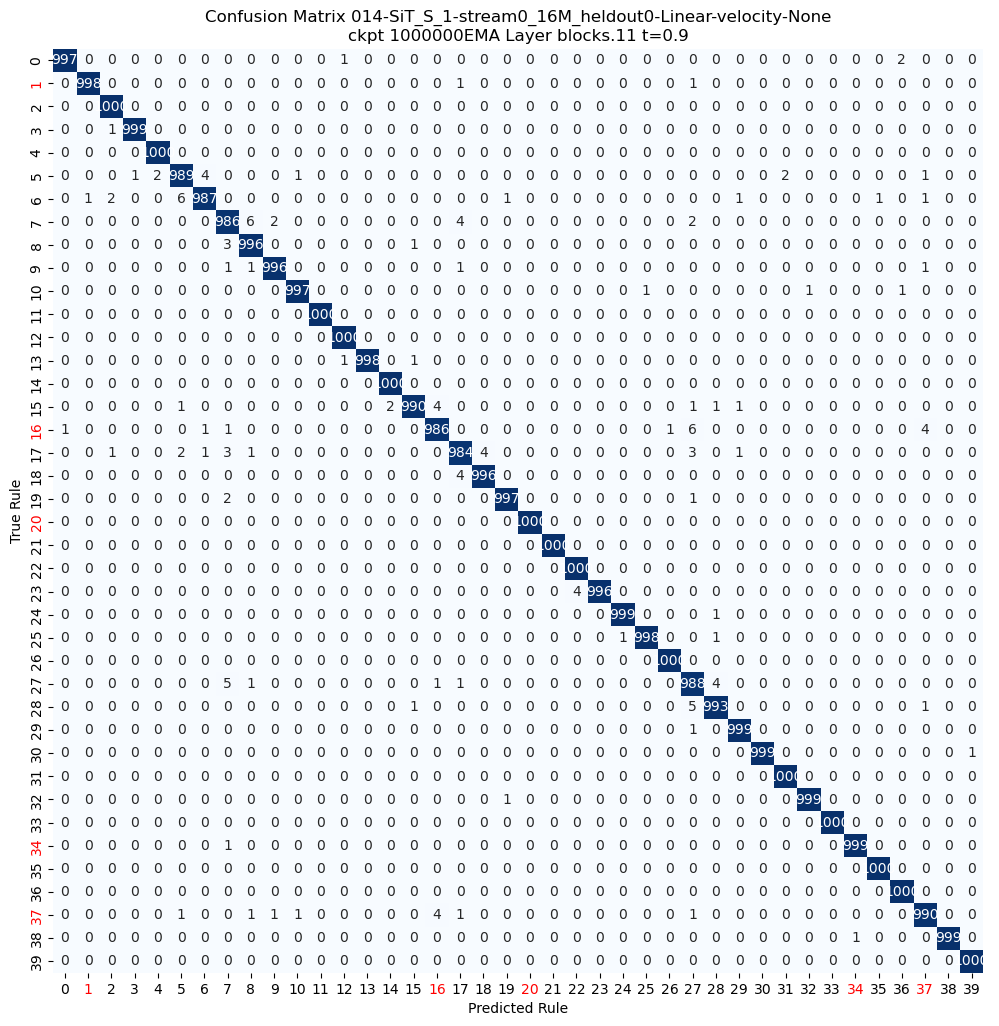

In [34]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
for t_scalar in [0.9]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt1000000EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        fig1, fig2 = visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"{expname}\nckpt 1000000EMA Layer {layer} t={t_scalar}")
        saveallforms(figexpdir, f"acc_per_rule_{layer}_t{t_scalar}_ckpt1000000EMA", fig1)
        saveallforms(figexpdir, f"rule_confmat_{layer}_t{t_scalar}_ckpt1000000EMA", fig2)

## Collapsed run

In [35]:
expname = r"013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]
# ckpt_path = join(ckptdir, "1000000.pt")
syn_df_SiT = sweep_classifier_result(repr_dir, t_list=[0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0,], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=True)

In [36]:
syn_df_SiT.to_csv(join(repr_dir, "repr_classifier_synopsis_EMA.csv"), index=False)
syn_df_SiT.to_csv(join(figexpdir, "repr_classifier_synopsis_EMA.csv"), index=False)

In [37]:
# find max and which row
print("Best classification result: ")
syn_df_SiT.loc[syn_df_SiT['Test Accuracy'].idxmax()]

Best classification result: 


Layer             blocks.11
Test Accuracy      0.893875
Train Accuracy     0.936892
t                       0.9
epoch                100000
dimred             avgtoken
Name: 799, dtype: object

In [38]:
# find max and which row
print("Top 5 classification result: ")
syn_df_SiT.loc[ syn_df_SiT['Test Accuracy'].nlargest(10).index ]

Top 5 classification result: 


Layer  Test Accuracy  Train Accuracy    t   epoch    dimred
799  blocks.11       0.893875        0.936892  0.9  100000  avgtoken
798   blocks.8       0.890925        0.930750  0.9  100000  avgtoken
729  blocks.11       0.873450        0.915400  0.8  100000  avgtoken
724  blocks.11       0.866400        0.909892  0.8  100000    pca384
728   blocks.8       0.856225        0.899400  0.8  100000  avgtoken
723   blocks.8       0.855800        0.897217  0.8  100000    pca384
654  blocks.11       0.841175        0.884392  0.7  100000    pca384
659  blocks.11       0.840025        0.882242  0.7  100000  avgtoken
653   blocks.8       0.830300        0.874300  0.7  100000    pca384
794  blocks.11       0.829475        0.875992  0.9  100000    pca384

In [40]:
# find max and which row
print("Best classification result: ")
# find Layer == 'blocks.11' t== 25.0 epoch == 1000000
syn_df_SiT.loc[ (syn_df_SiT['Layer'] == 'blocks.11') & 
                (syn_df_SiT['t'] == 0.9) & 
                (syn_df_SiT['epoch'] == 100000) ]

Best classification result: 


Layer  Test Accuracy  Train Accuracy    t   epoch    dimred
794  blocks.11       0.829475        0.875992  0.9  100000    pca384
799  blocks.11       0.893875        0.936892  0.9  100000  avgtoken

### Scaling with diffusion time

#### Early in training 0.1M step

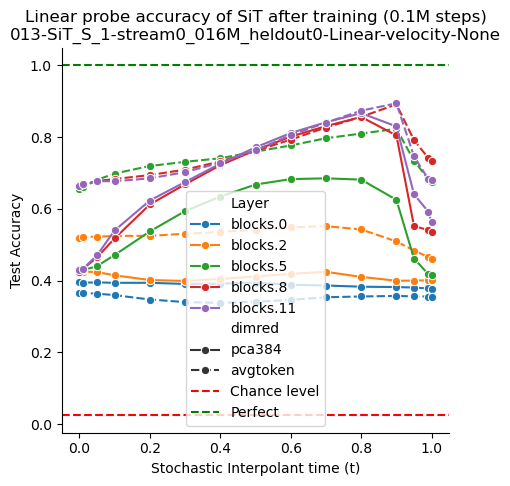

In [51]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[syn_df_SiT.epoch==100000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (0.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_alldimred_EMA", figh)

The first two dots were t=0 and t=1 which maybe weird due to lack of training? / too close to the clean image 

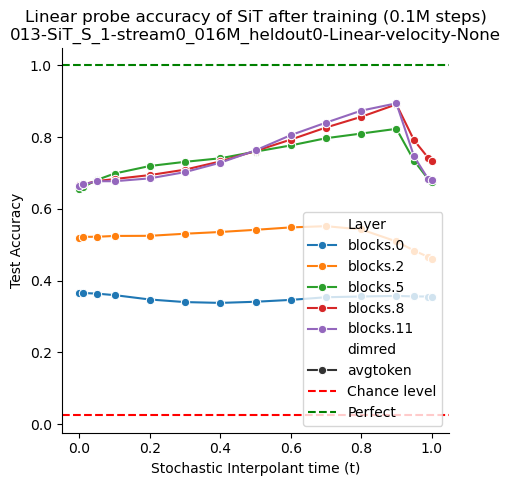

In [52]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==100000) & (syn_df_SiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (0.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_avgtoken_EMA", figh)

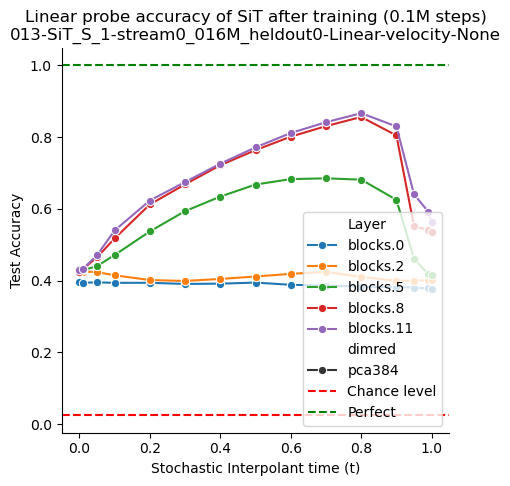

In [53]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==100000) & (syn_df_SiT.dimred=="pca384")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (0.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_pca384_EMA", figh)

#### End of training 1M steps

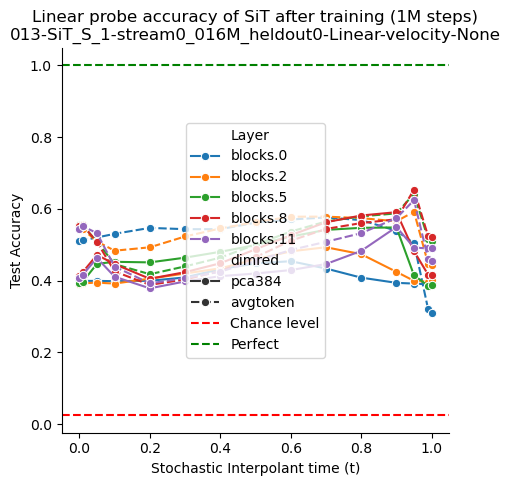

In [54]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[syn_df_SiT.epoch==1000000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_alldimred_EMA", figh)

The first two dots were t=0 and t=1 which maybe weird due to lack of training? / too close to the clean image 

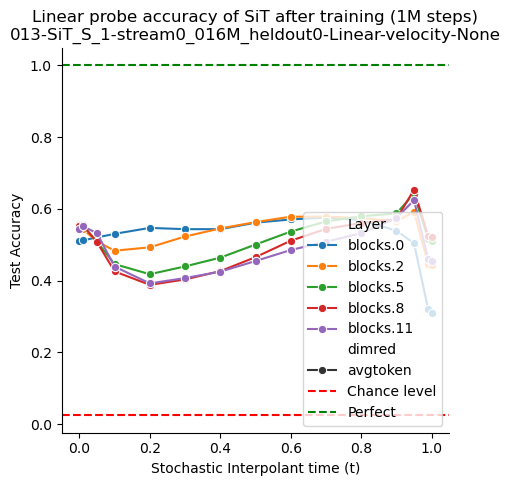

In [55]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==1000000) & (syn_df_SiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA", figh)

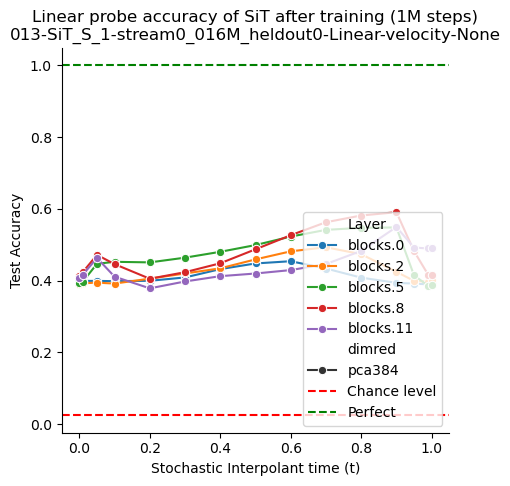

In [56]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.epoch==1000000) & (syn_df_SiT.dimred=="pca384")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("Stochastic Interpolant time (t)")
plt.title(f"Linear probe accuracy of SiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_pca384_EMA", figh)

### Scaling with training time

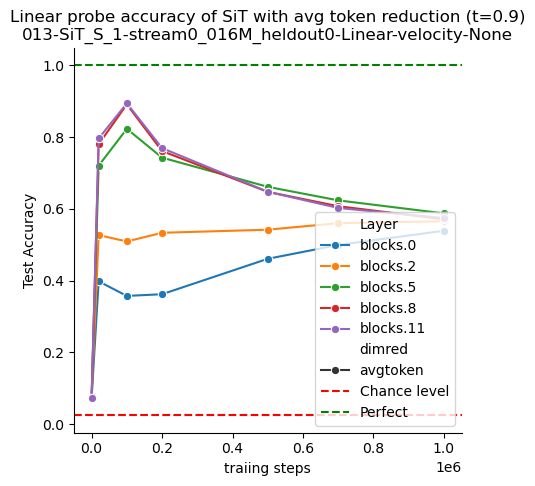

In [41]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="avgtoken")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_avgtoken_EMA", figh)
plt.show()

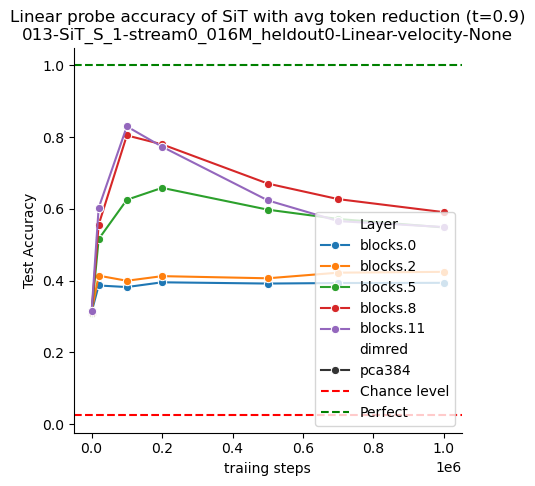

In [42]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="pca384")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_pca384_EMA", figh)
plt.show()

### Scaling with layer depth

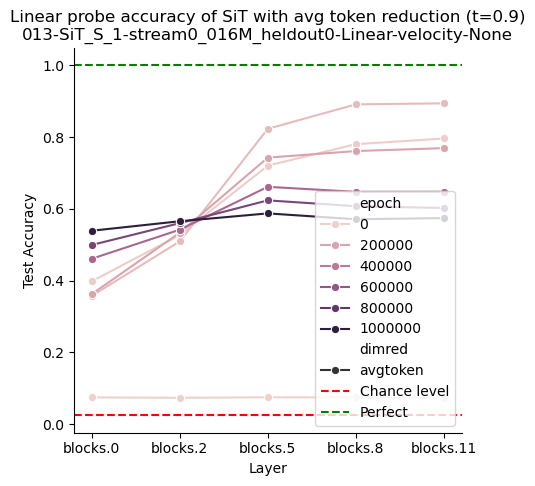

In [43]:
t_scalar = 0.9
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="avgtoken")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of SiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_avgtoken_EMA", figh)

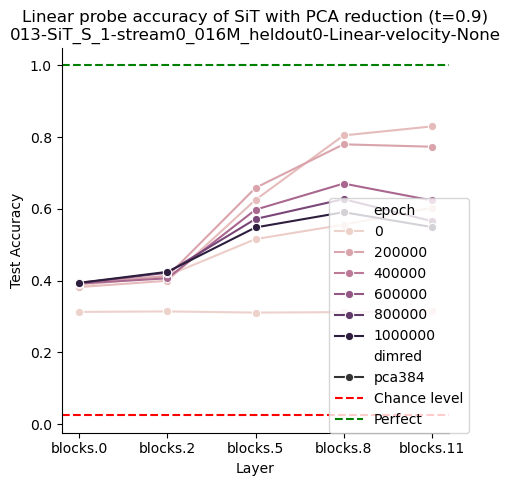

In [44]:
t_scalar = 0.9
figh = plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_SiT[(syn_df_SiT.t==t_scalar) & (syn_df_SiT.dimred=="pca384")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of SiT with PCA reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
# put legend outside
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.0), borderaxespad=0.)
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_pca384_EMA", figh)

## Old Scratch code

#### Confusion matrix of rule classification based on internal rules

In [21]:
from matplotlib.patches import Rectangle

def visualize_cm(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    for rule_id in heldout_rules:
        row = rule_id // 10
        col = rule_id % 10
        plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

In [37]:
results_col['blocks.0']['pred_cls']

tensor([32,  0, 19,  ..., 39, 39, 39], device='cuda:0')

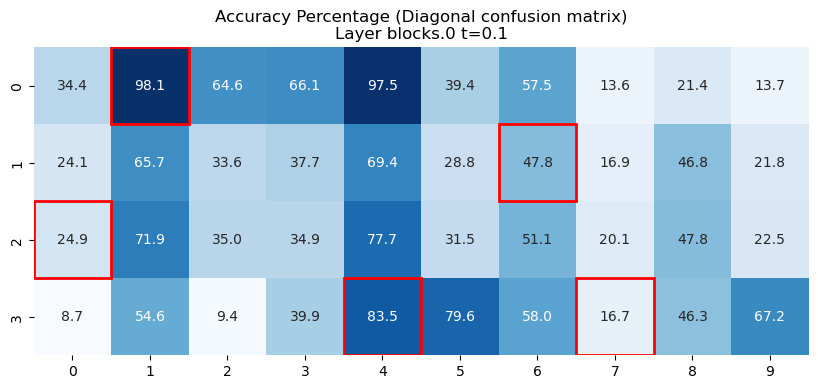

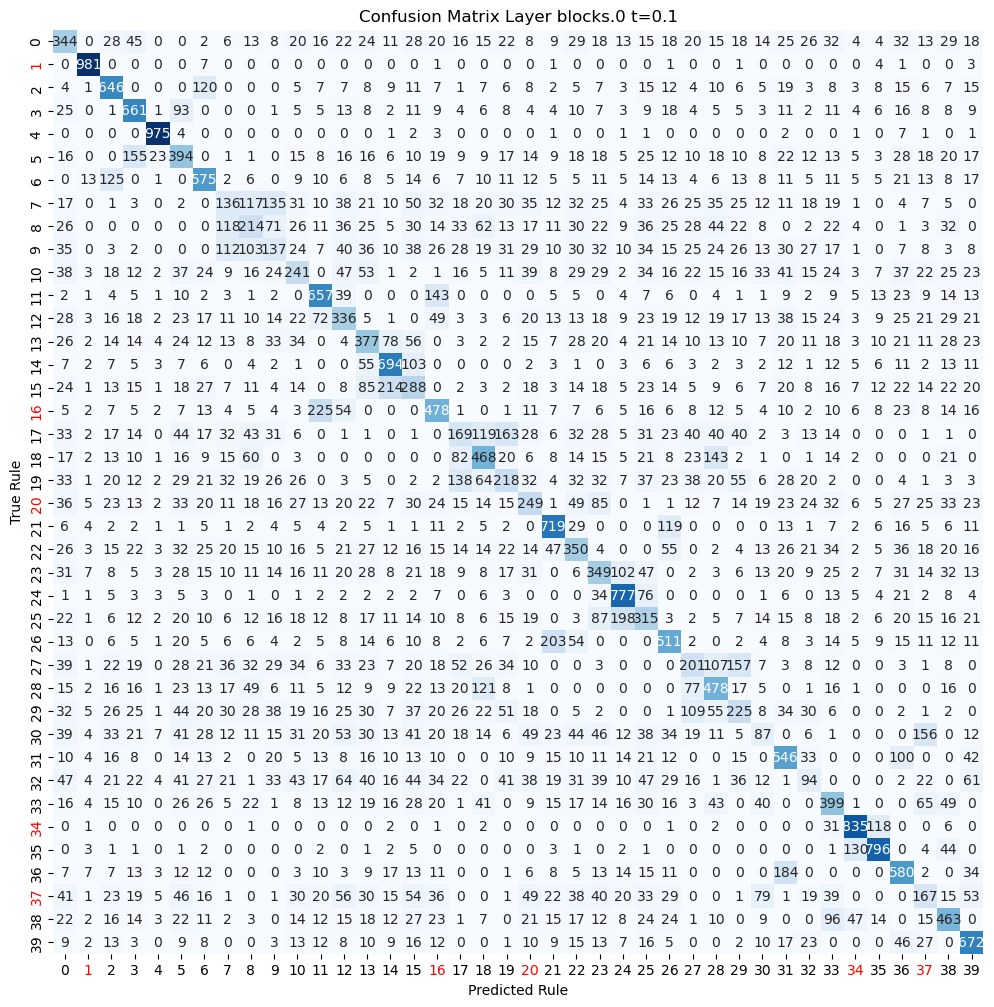

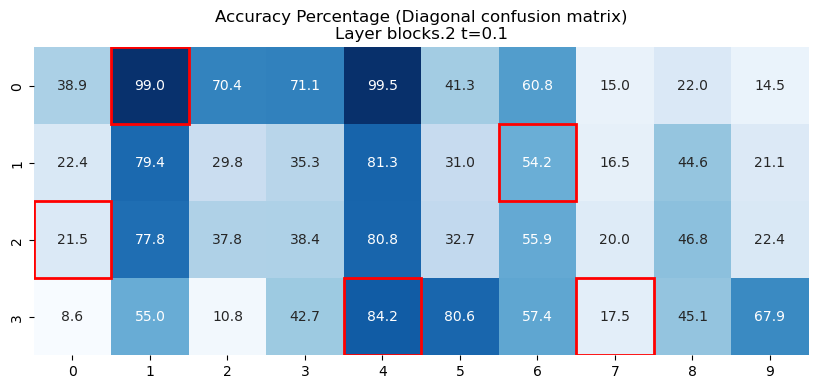

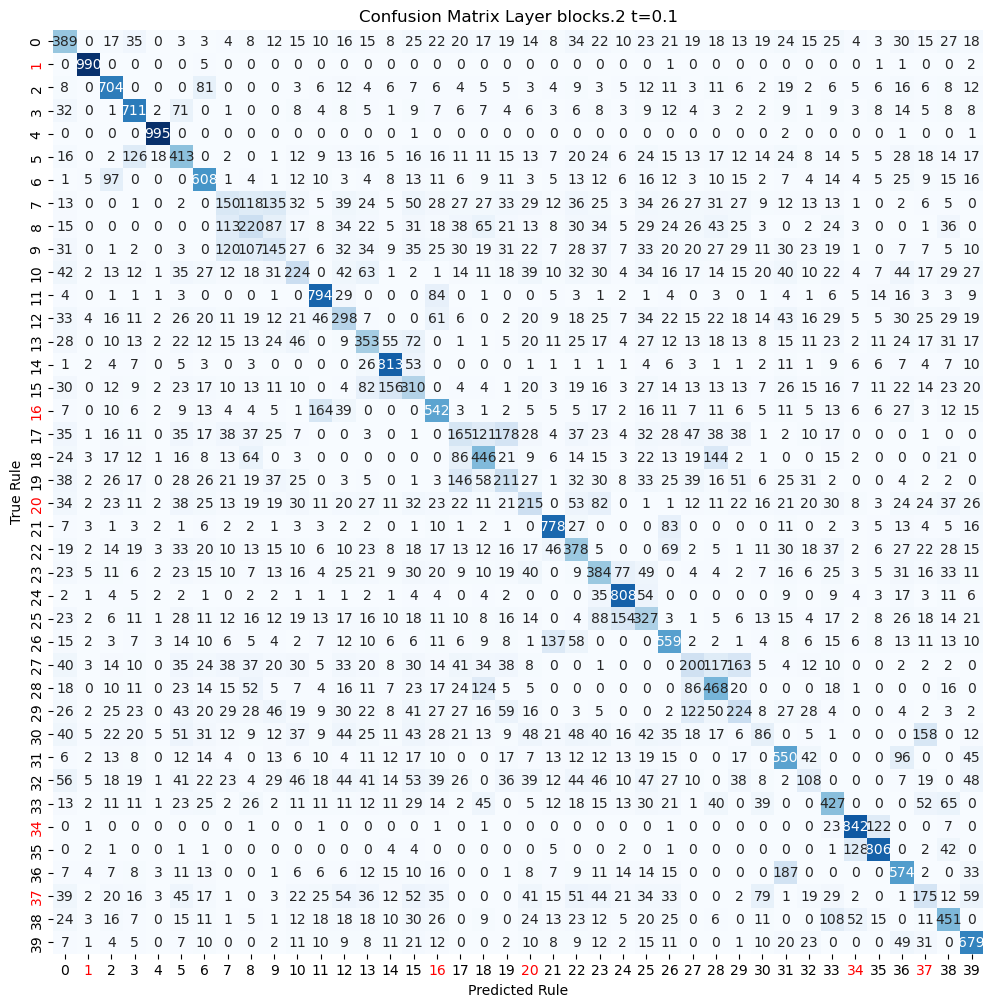

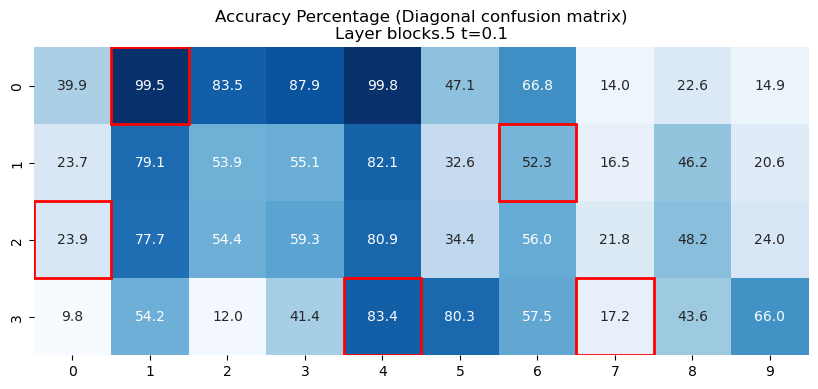

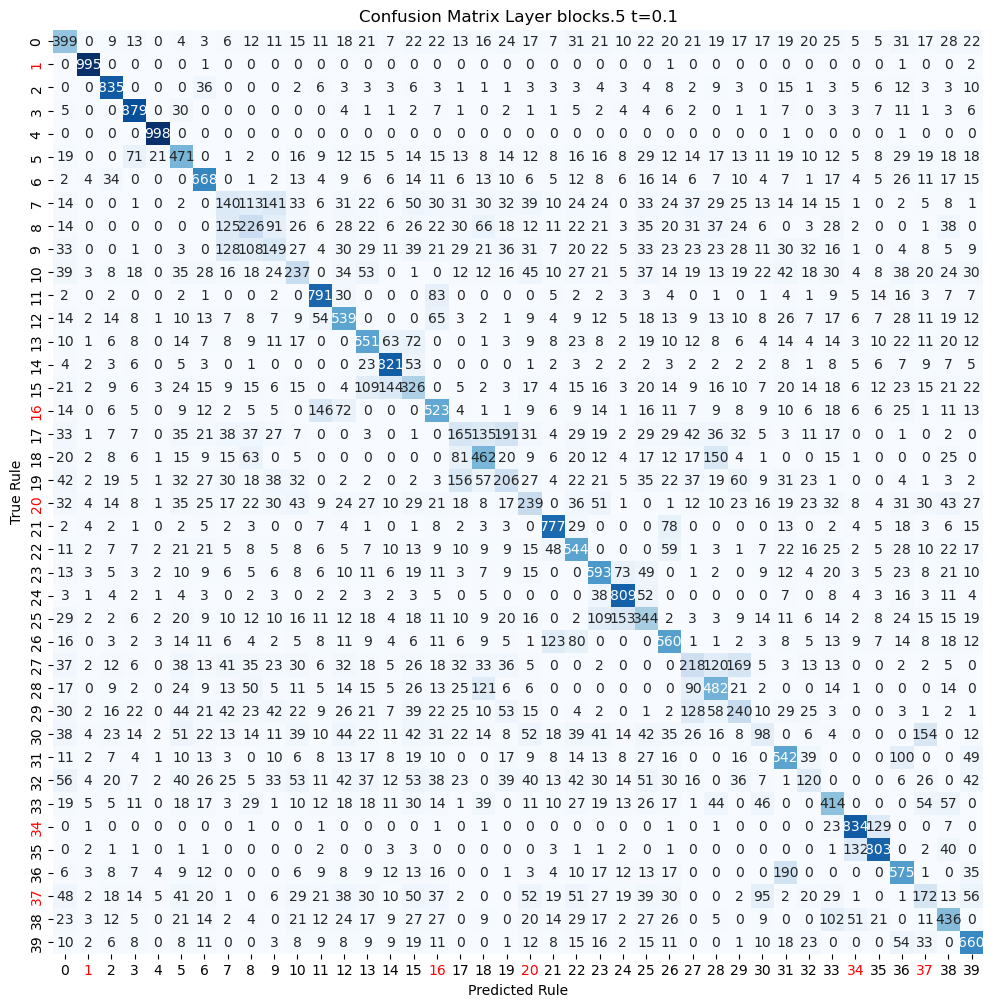

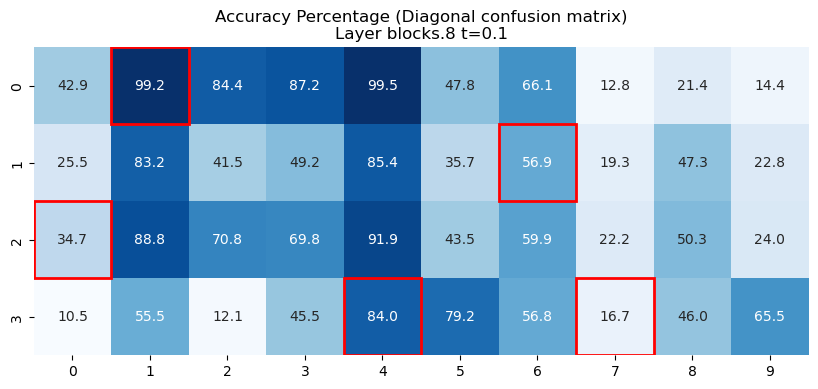

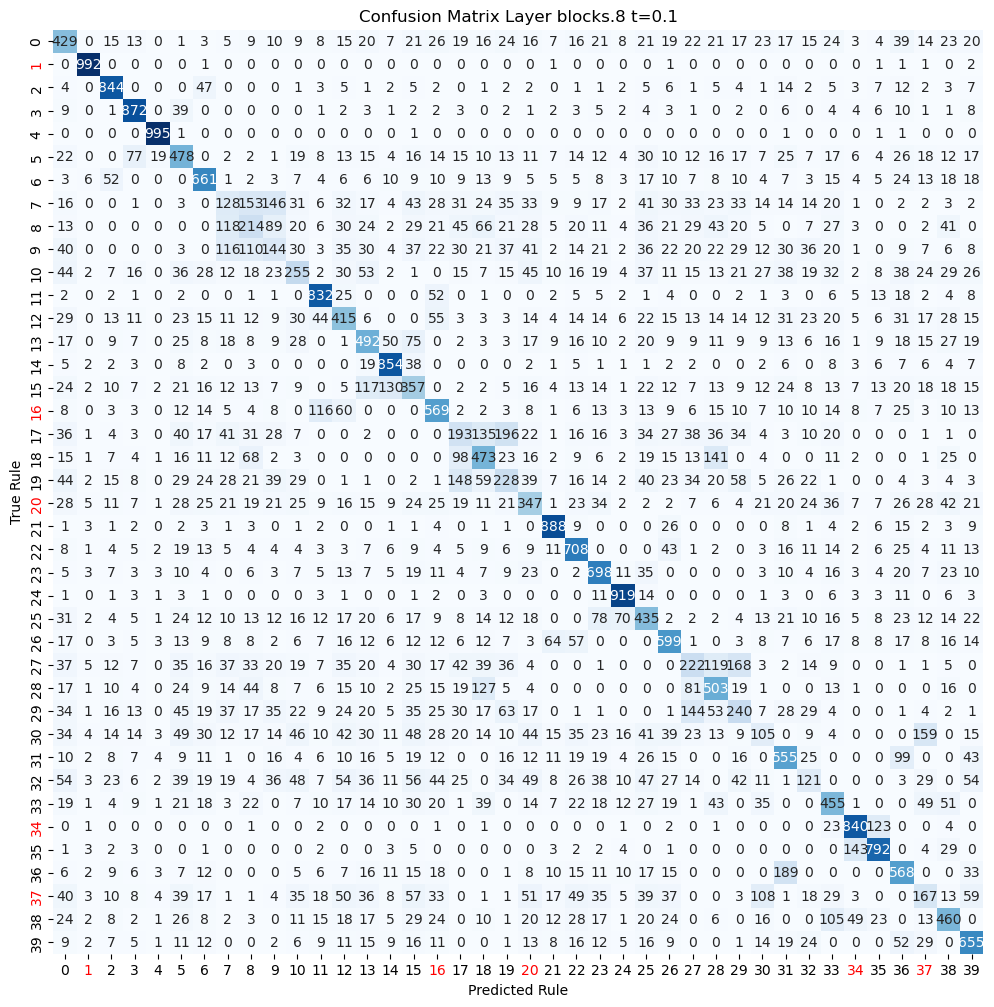

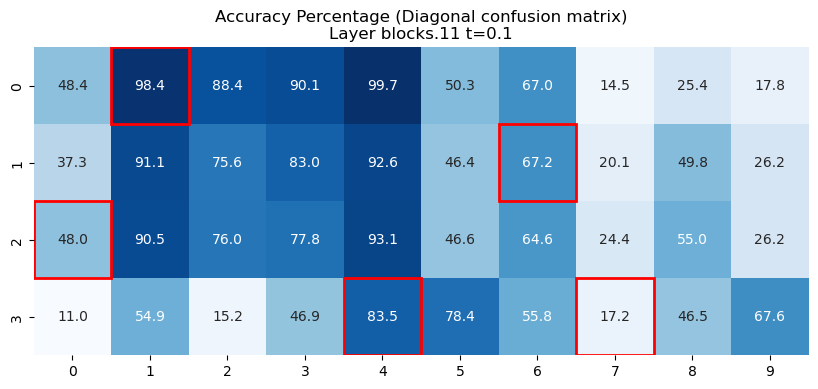

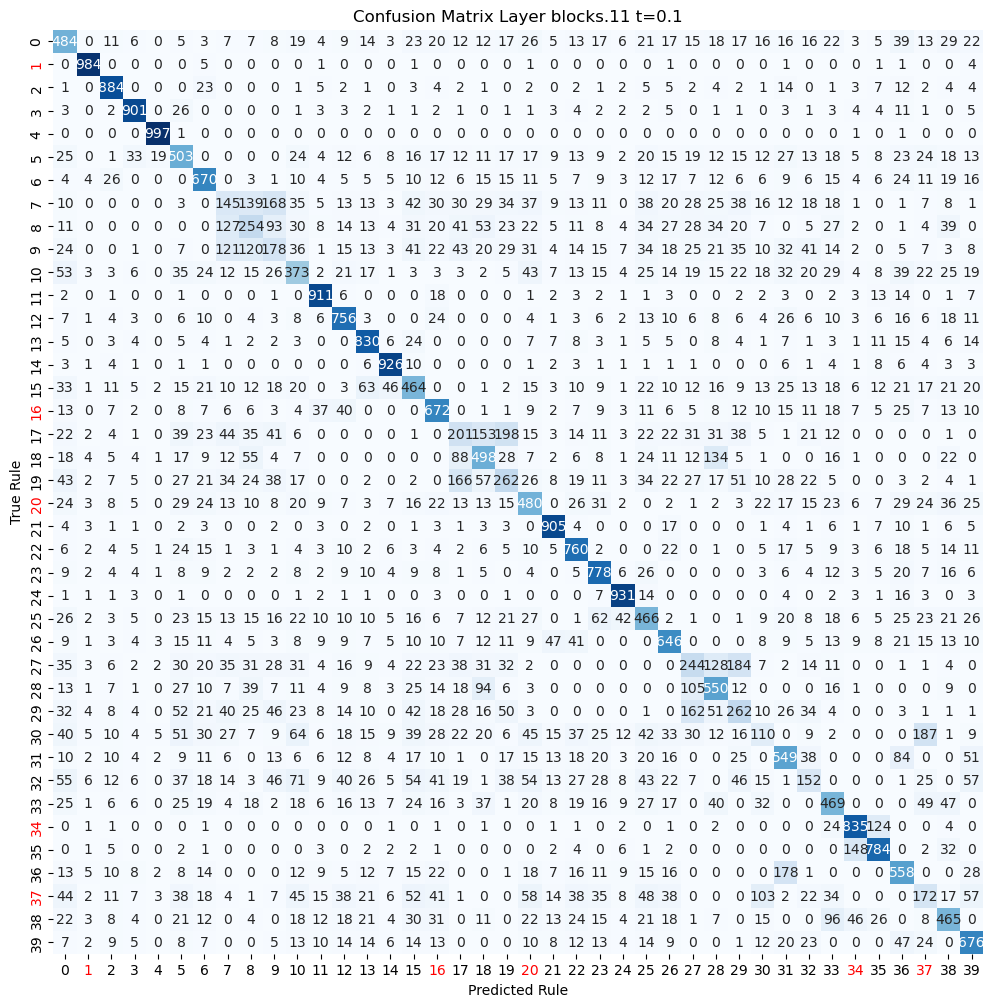

In [10]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.1]:#[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")

#### Confusion matrix of relation and rule attr dim

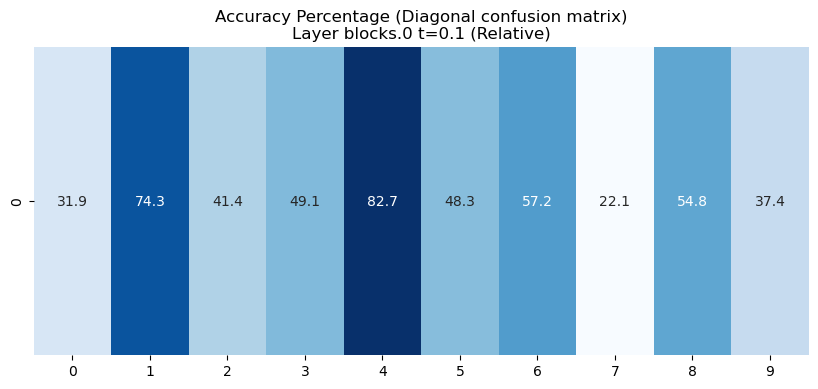

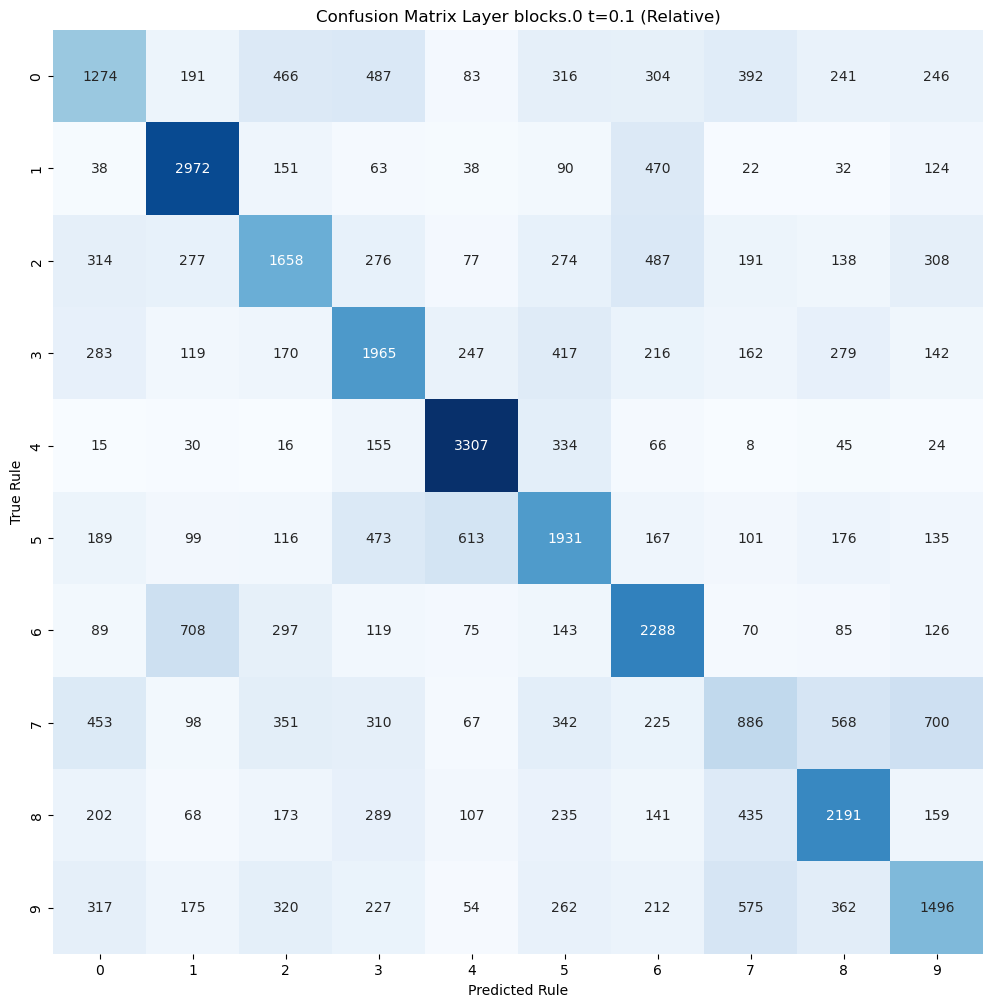

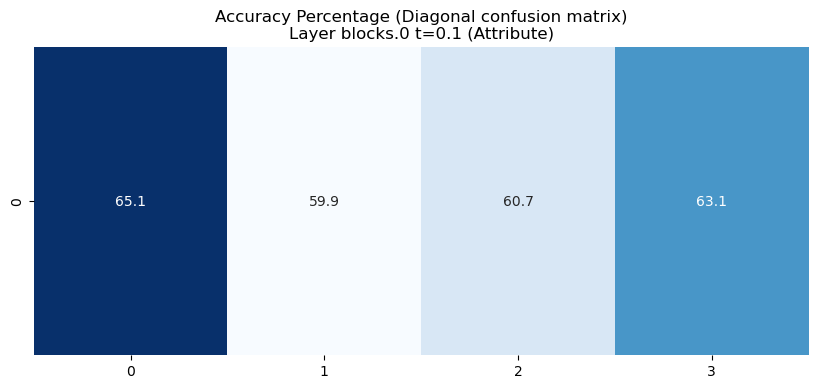

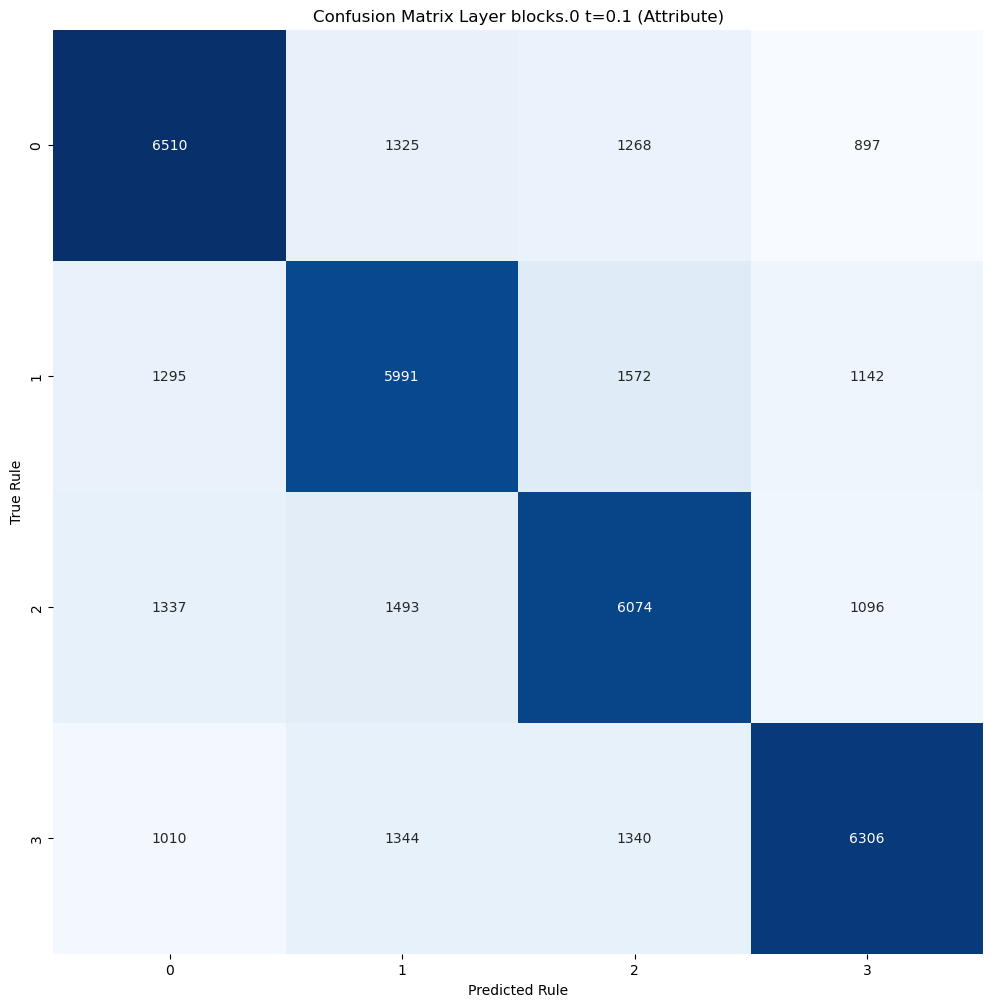

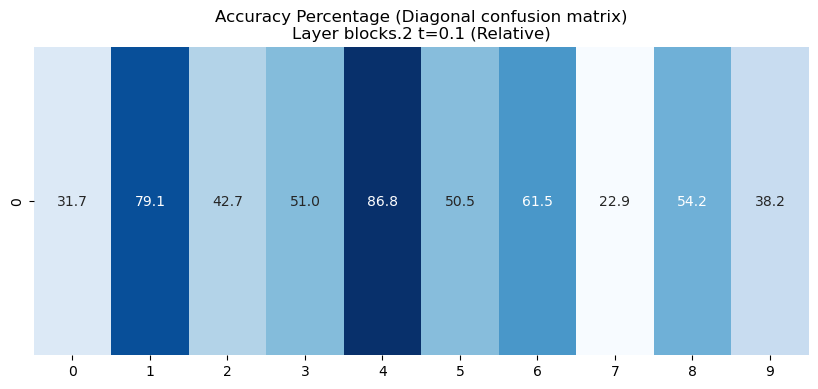

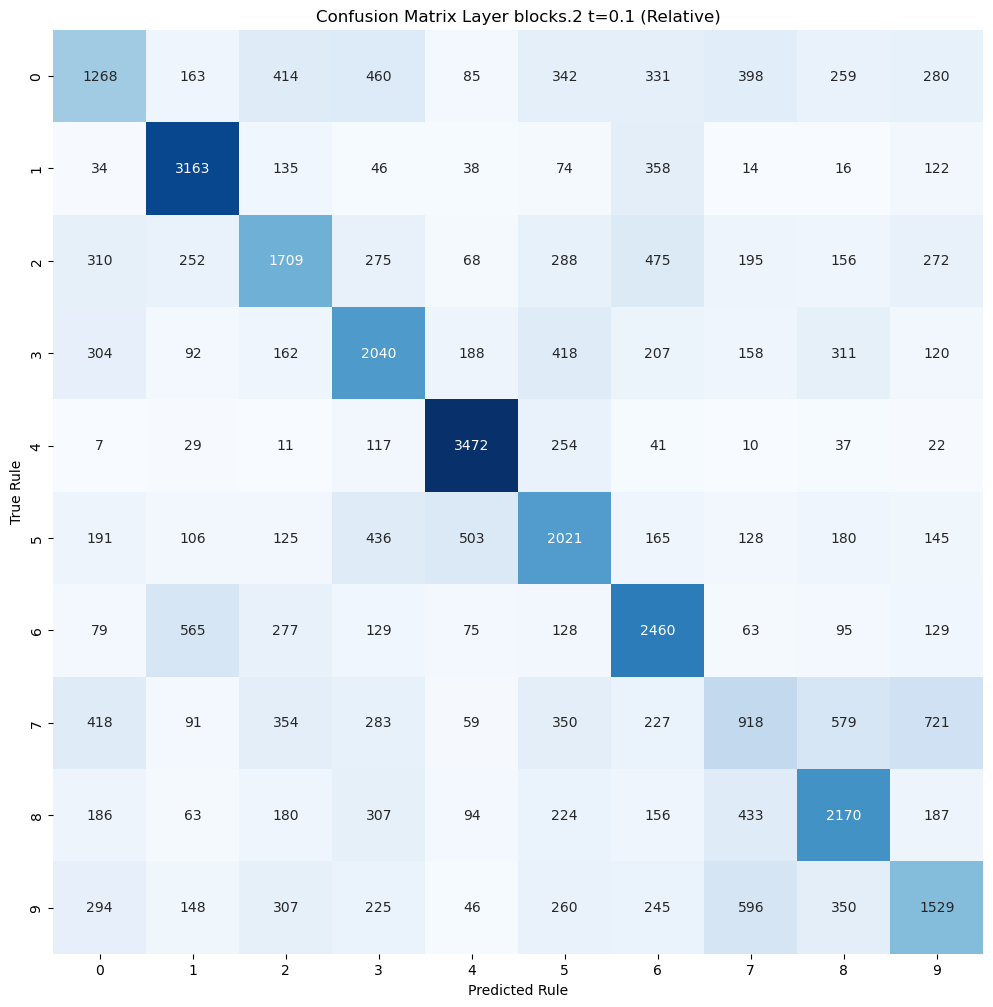

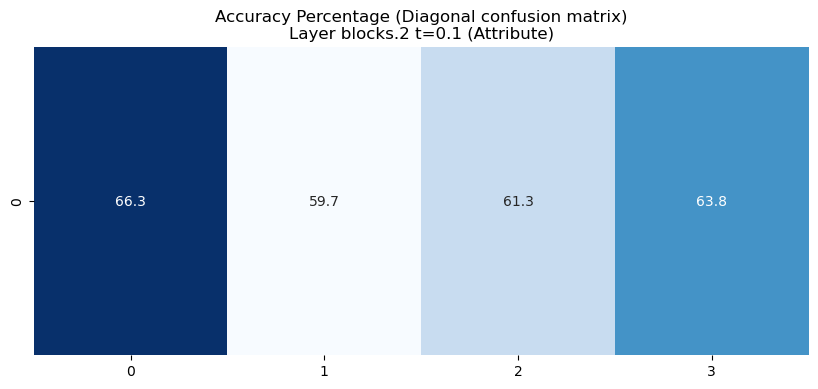

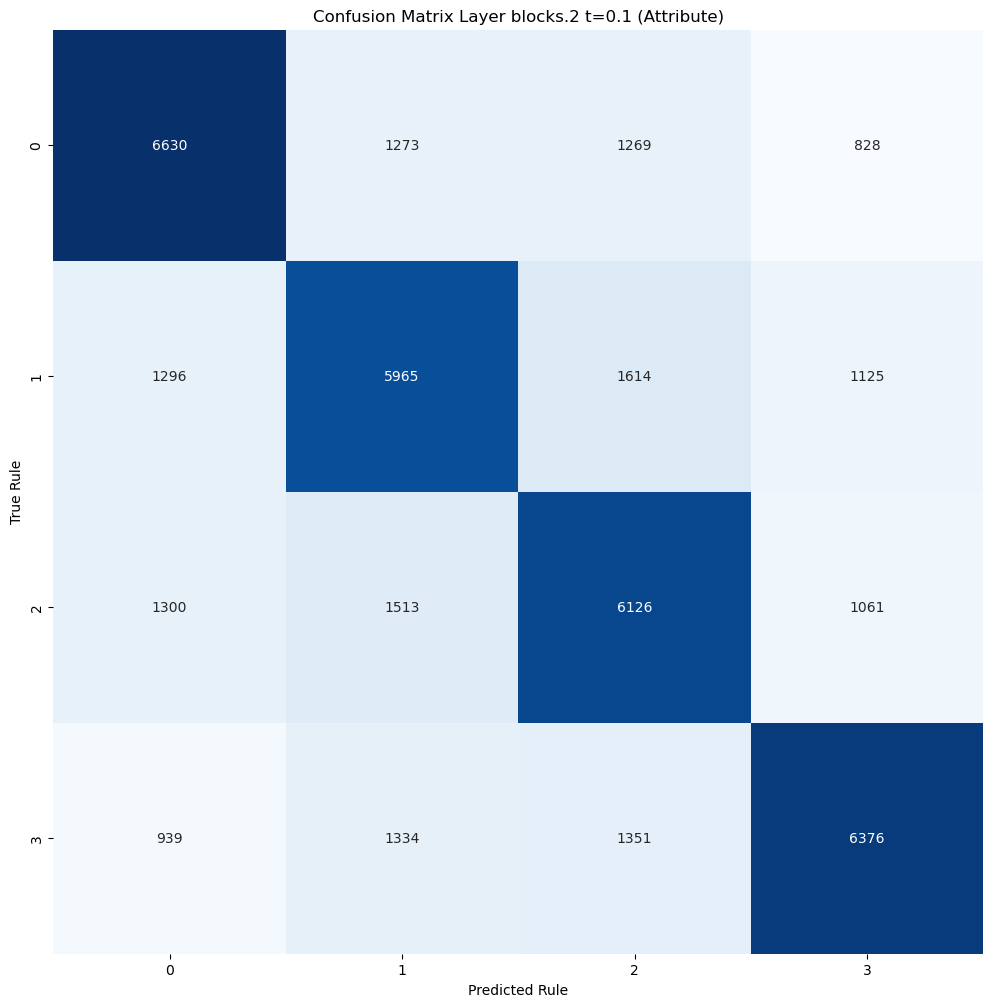

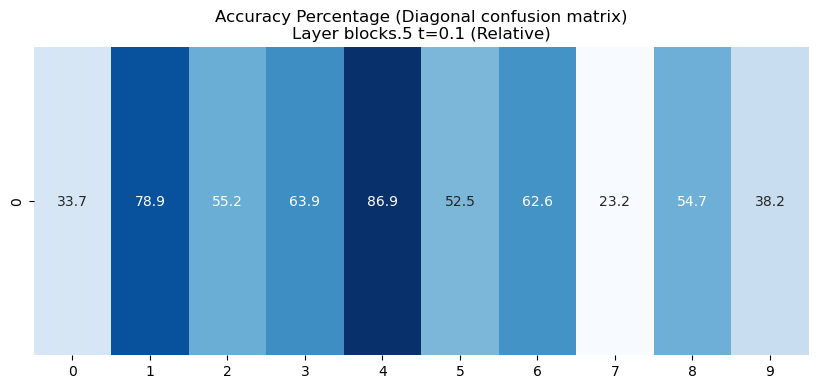

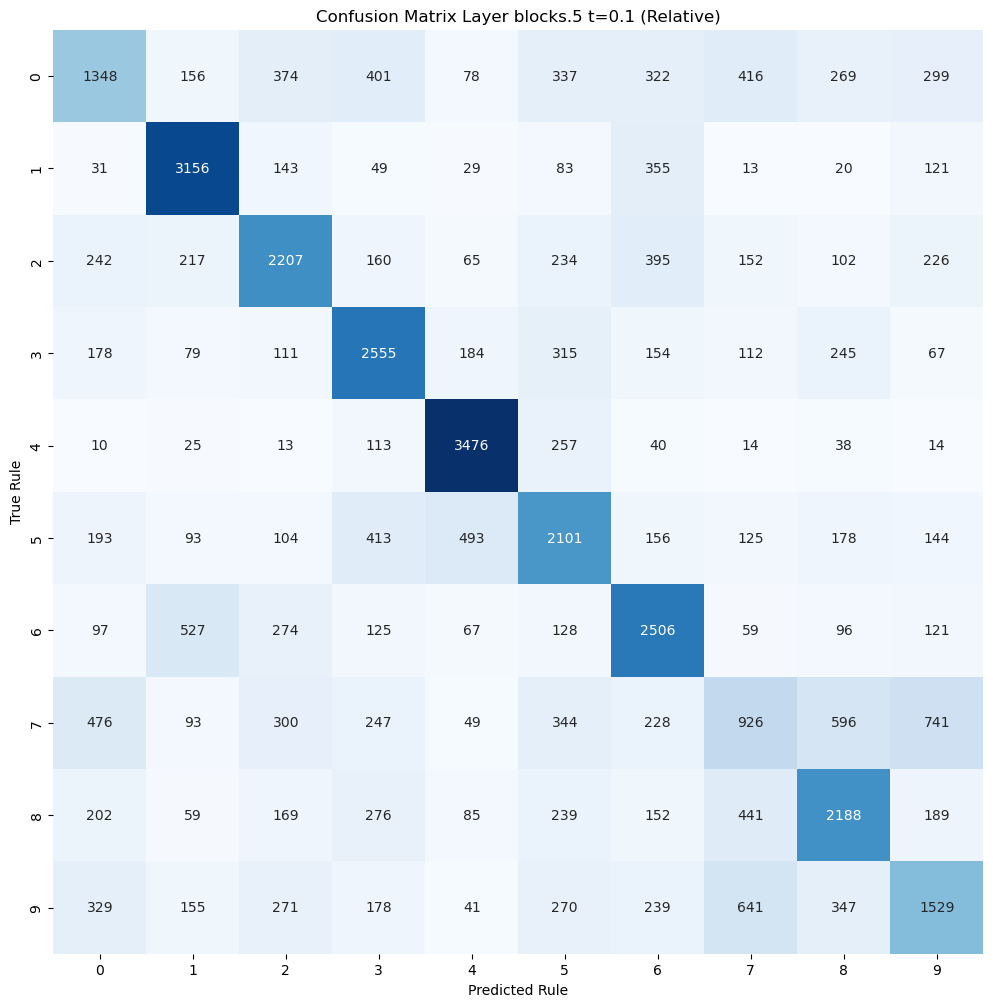

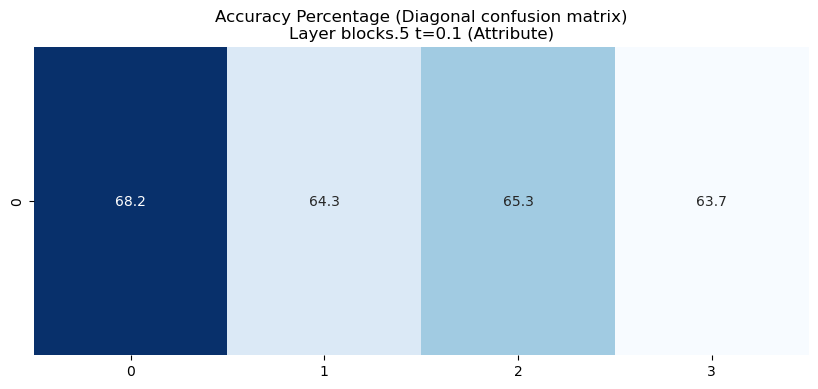

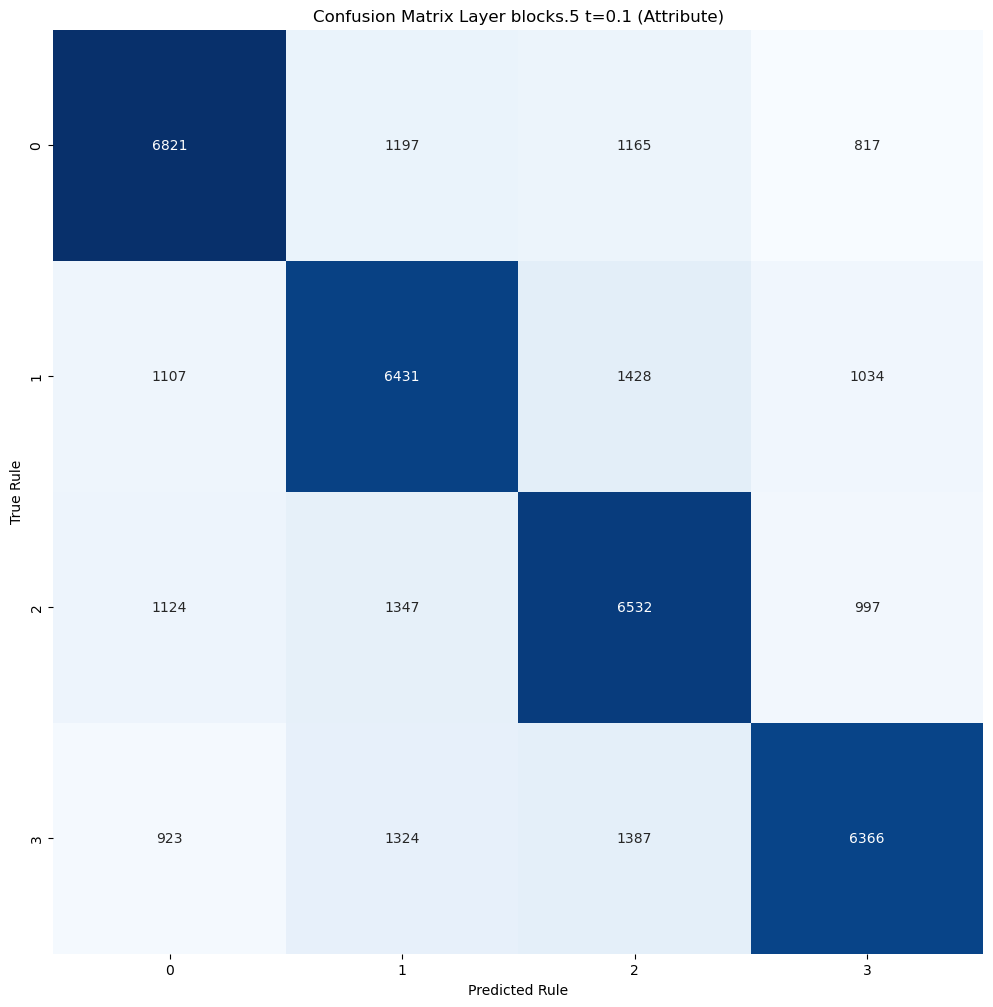

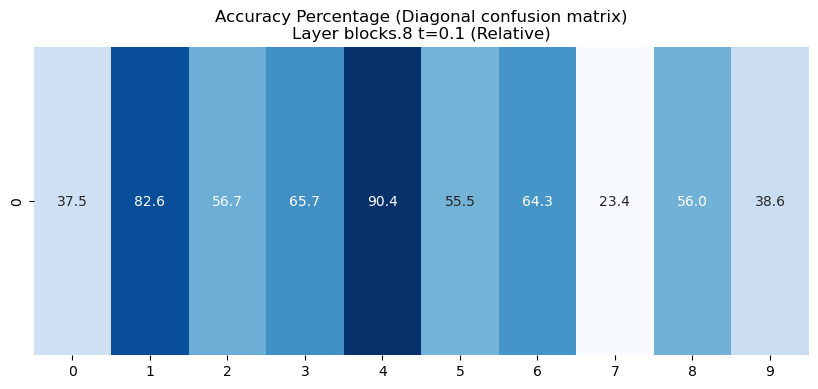

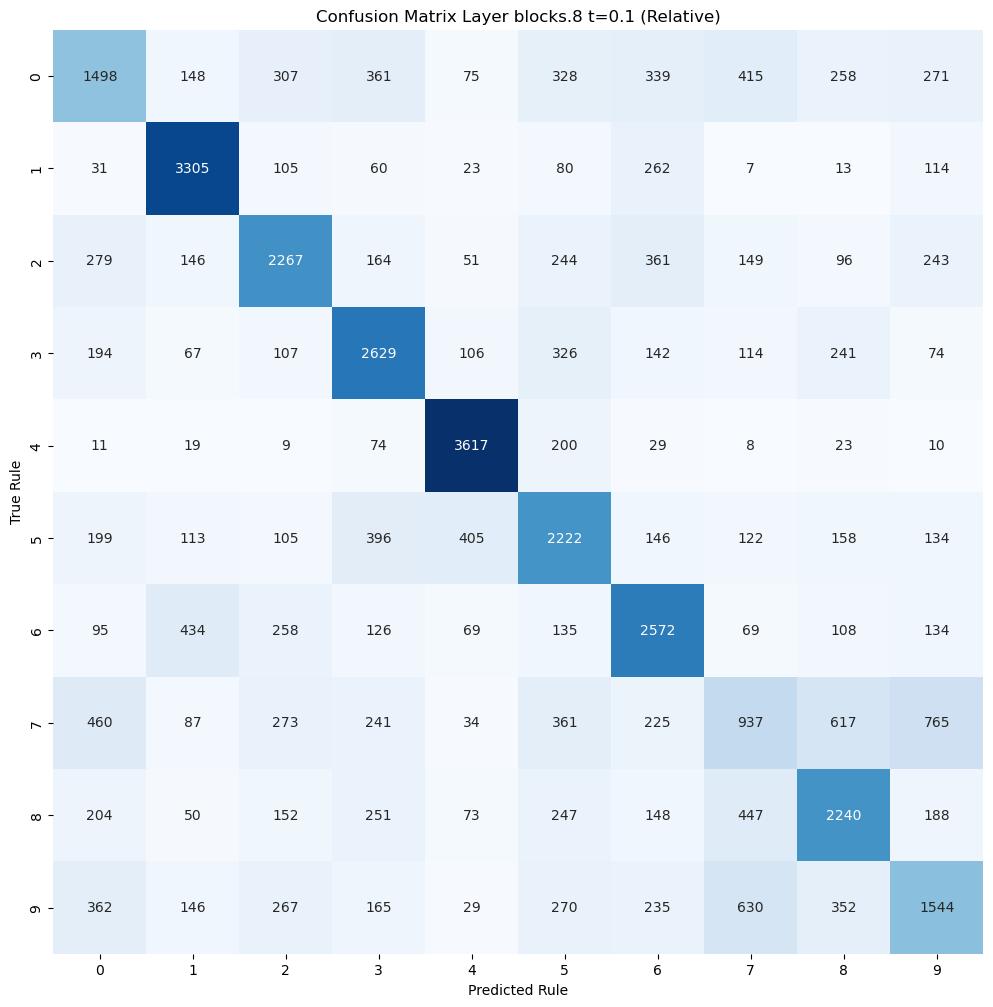

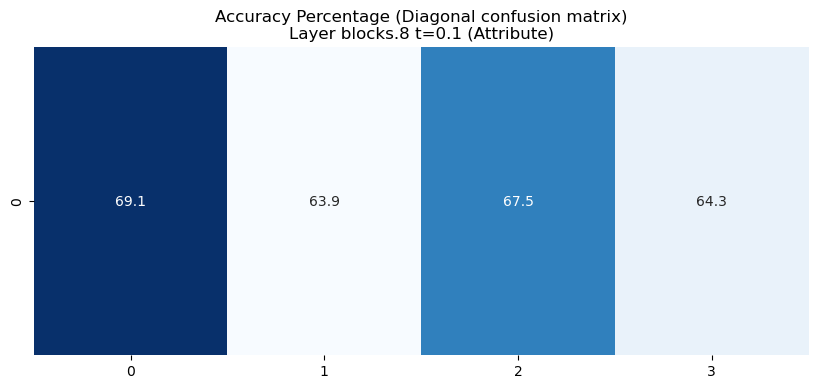

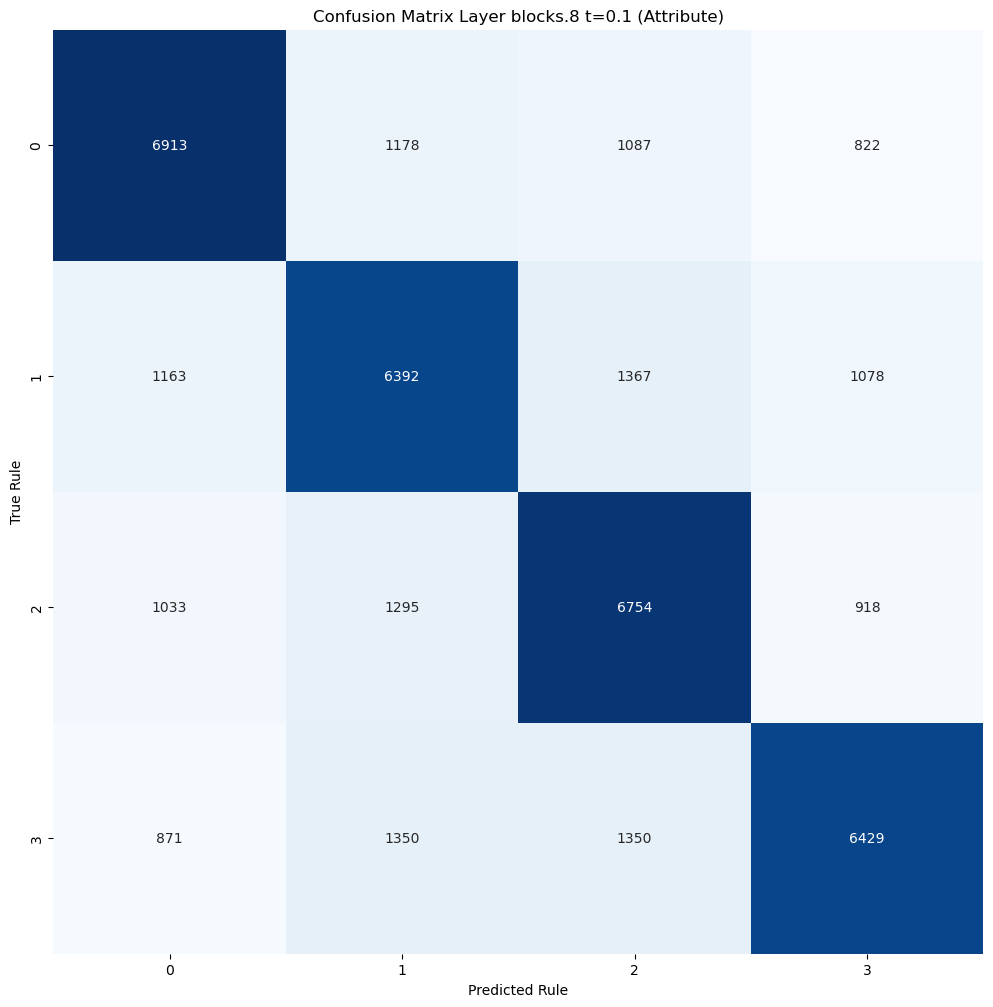

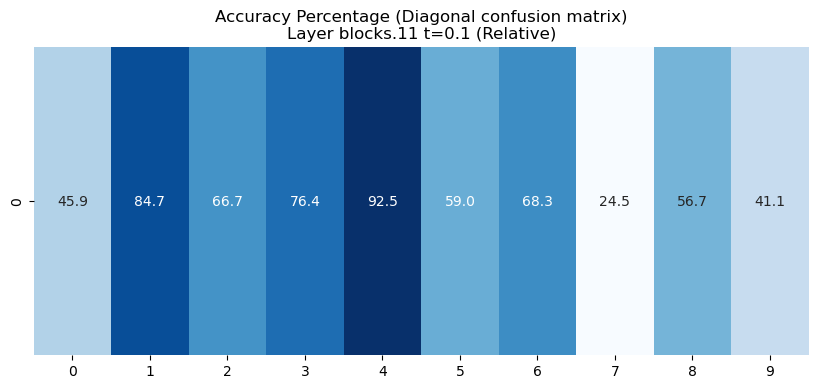

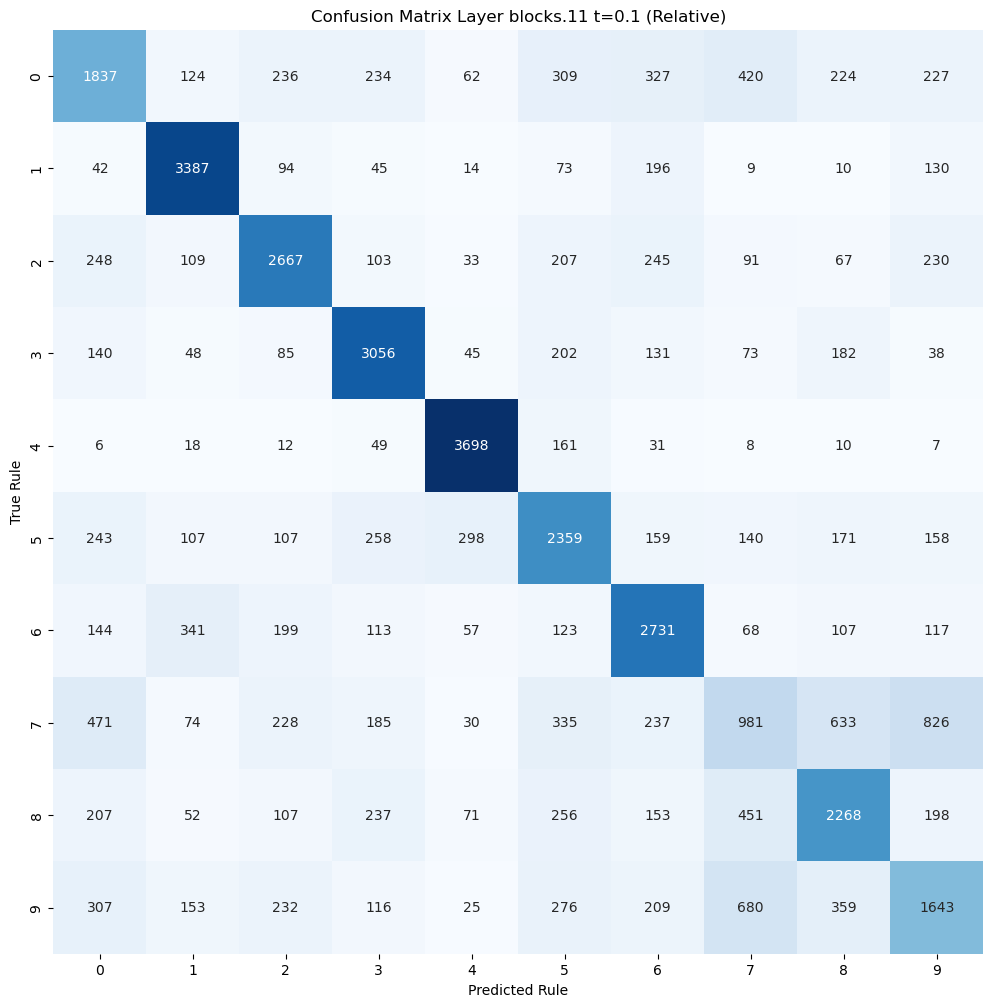

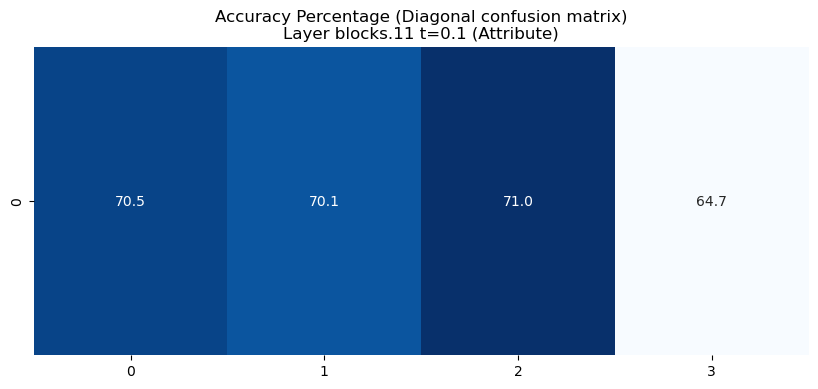

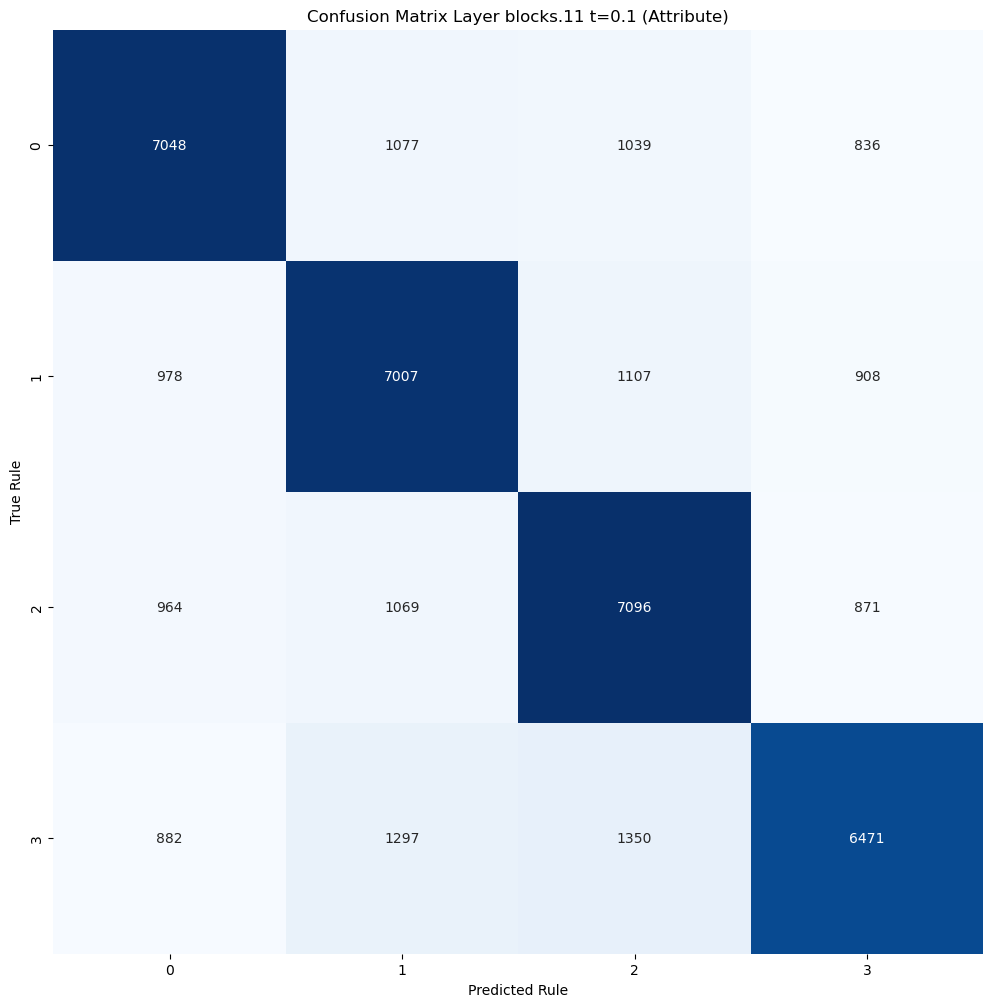

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
syn_df_all = []
t_scalar = 0.1
for t_scalar in [0.1]:#[0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC1024.pkl"), "rb"))
    for key in results_col.keys():
        pred_cls = results_col[key]['pred_cls'].cpu()
        # cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        # visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar}")
        cm_rel = confusion_matrix(y_true=y_test % 10, y_pred=pred_cls % 10, )
        visualize_cm_default(cm_rel, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar} (Relative)")
        cm_attr = confusion_matrix(y_true=y_test // 10, y_pred=pred_cls // 10, )
        visualize_cm_default(cm_attr, heldout_rules=heldout_rules, titlestr=f"Layer {key} t={t_scalar} (Attribute)")